# Ultimate Technologies Take Home Challenge
---
## Part 1 - Exploratory Data Analysis

## Part 2 - Experiement and Metrics Design

## Part 3 - Predictive Modelling
---

# PART 1 - EDA

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import datetime

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier, cv, plot_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in data and prep for resample
logins_df = pd.read_json('logins.json')
logins_df['login_count'] = 1

# Convert timestamps to datetime objects and set them to index
logins_df = logins_df.set_index(pd.to_datetime(logins_df['login_time'], unit='s'))[['login_count']]
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
login_count    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


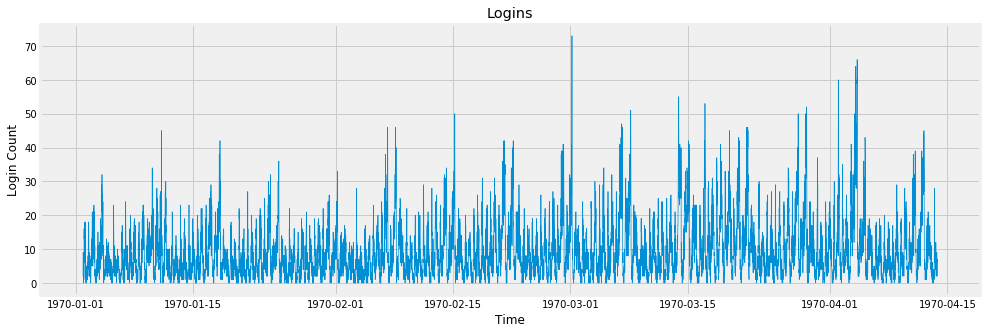

In [3]:
# Resample and visualize the login info
logins_resampled = logins_df.resample('15Min').sum()

fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.title('Logins')
plt.plot(logins_resampled.index, logins_resampled.login_count, linewidth=.7);

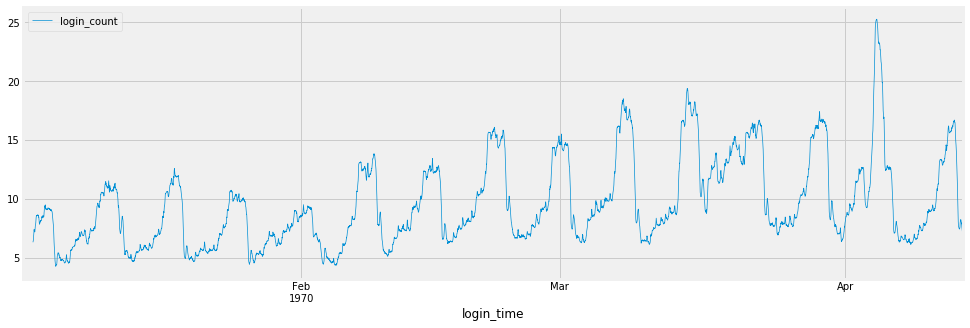

In [4]:
# Let's apply some smoothing to see our trends a bit more clearly
logins_resampled.rolling(window=100).mean().plot(figsize=(15, 5), linewidth=.7)
plt.show()

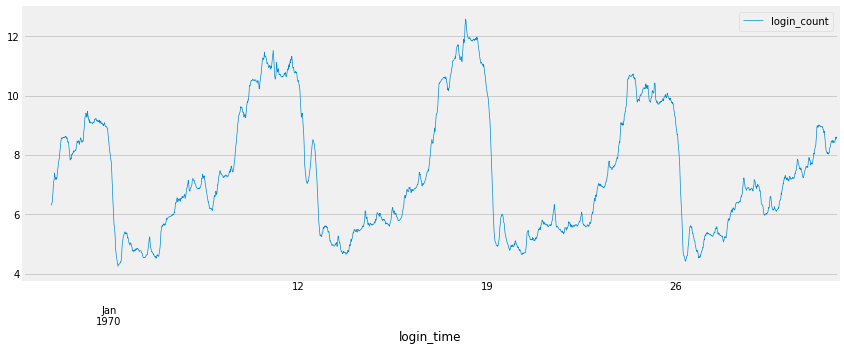

In [5]:
# Let's zoom into one month
logins_resampled.loc['1970-01'].rolling(window=100).mean().plot(figsize=(13, 5), linewidth=.7)
plt.show()

In [6]:
# Let's orient ourselves
datetime.datetime(1970, 1, 5).weekday()

0

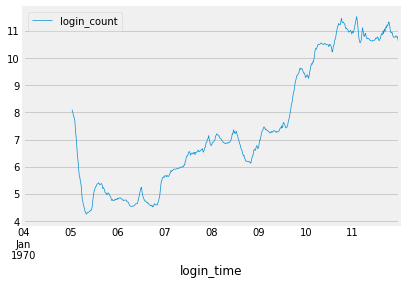

In [7]:
# Great, so January 5, 1970 was a monday. Lets zoom into that week. 
logins_resampled.loc['1970-01-04':'1970-01-11'].rolling(window=100).mean().plot(linewidth=.7)
plt.show()

# Looks like demand increases throughout the week and peaks on the weekends. 

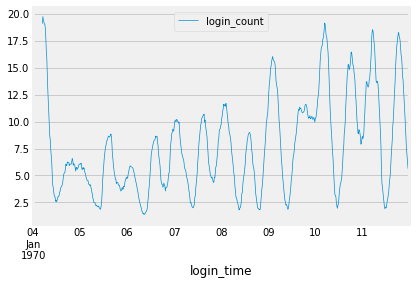

In [8]:
# What happens when we allow some of the details back in by reducing widow size?
logins_resampled.loc['1970-01-04':'1970-01-11'].rolling(window=20).mean().plot(linewidth=.7)
plt.show()

# We can see a daily cycle reveal itself

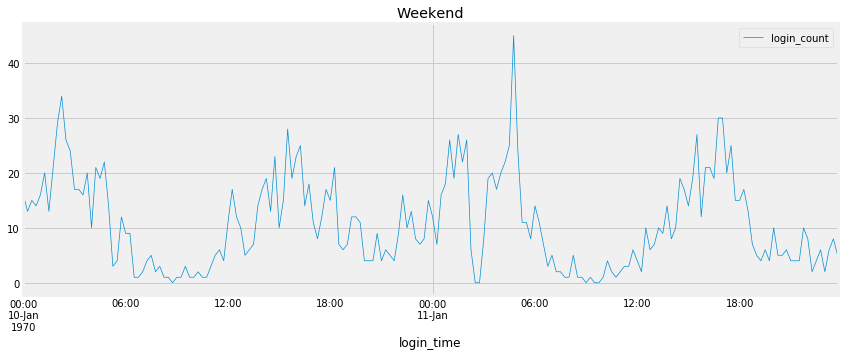

In [9]:
# Let's take a closer look at a weeked
logins_resampled.loc['1970-01-10':'1970-01-11'].plot(figsize=(13, 5), linewidth=.7)
plt.title('Weekend')
plt.show()

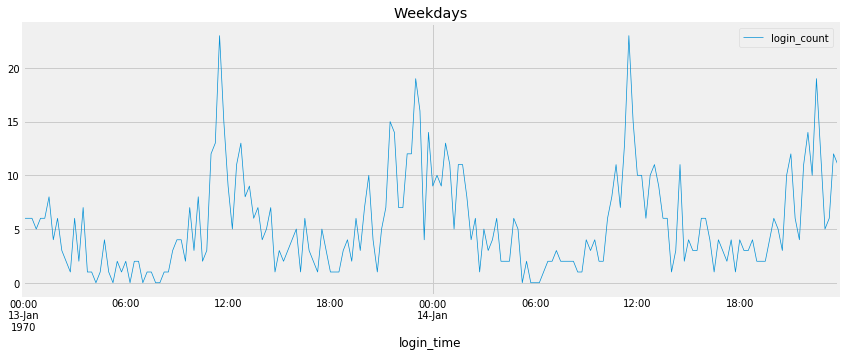

In [10]:
# And compare that with two weekdays 
logins_resampled.loc['1970-01-13':'1970-01-14'].plot(figsize=(13, 5), linewidth=.7)
plt.title('Weekdays')
plt.show()

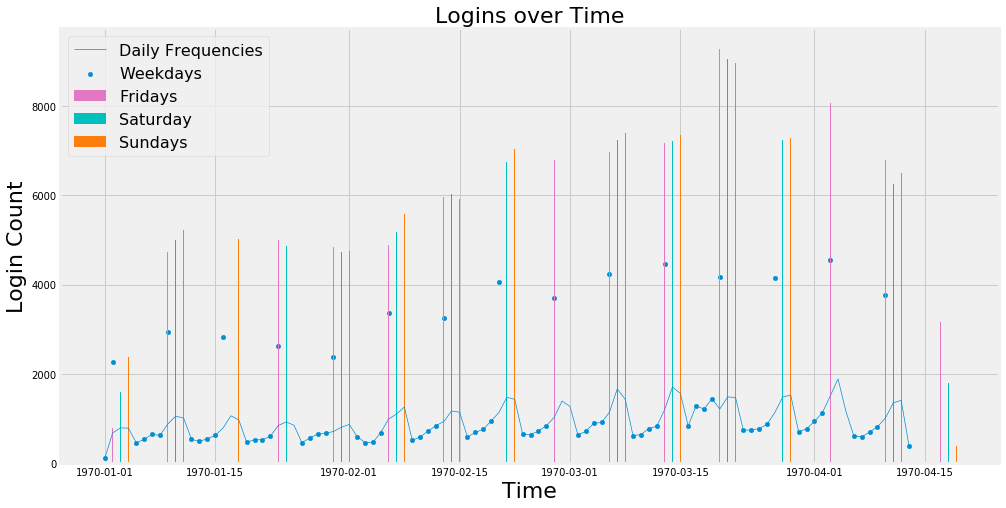

In [11]:
# It seems that week days have traffic spikes around noon and midnight whereas weekends
# peak in the early morning and early evening. Let's get some more insights about this. 

# bin data by the day
logins_daily = logins_df.resample('D').sum()
logins_biz_day = logins_df.resample('B').sum()
fridays = logins_df.resample('W-FRI').sum()
saturdays = logins_df.resample('W-SAT').sum()
sundays = logins_df.resample('W-SUN').sum()

# line, scatterplot, and histograms of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Login Count', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.bar(fridays.index, fridays.login_count, align= 'center'\
                                          , width = 0.1\
                                          , label = "Fridays"\
                                          , color = 'tab:pink')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday'\
                                              , align = 'center'\
                                              , width = 0.1\
                                              , color = 'C')
plt.bar(sundays.index, sundays.login_count, label = "Sundays"\
                                          , align= 'center'\
                                          , width = 0.1\
                                          , color = 'tab:orange')
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies'\
                                                     , linewidth=.7)
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays', s=20)

plt.legend(loc='upper left', fontsize = 16);

Viewing the whole trend, we observe that demand is highest in March. Throughout, weekends bring the most traffic. 

# PART 2 - Experiment and Metrics Design

1. The key measure of sucess I would use is to determine the average traffic across the bridges at critical times. If the reimbursement program has the desired effect, there will be an increase in traffic across the bridge after the reimbursements have been issued. 
2. In order to determine the validity of the toll reimbursements, I will measure the traffic averages two weeks before and two weeks after the changes have been made. I will use a z-test to determine the statistical significance of our observations. It is worth noting that two weeks may not be long enough to determine the long term trends


In [12]:
# This portion is adopted from mtchems approach

# Load data
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)

# Create dataframe
users_df = pd.DataFrame(data)

# Convert dates to datetime objects
users_df['signup_date'] = pd.to_datetime(users_df['signup_date'])
users_df['last_trip_date'] = pd.to_datetime(users_df['last_trip_date'])

# When was our data pulled?
pull_date = users_df.last_trip_date.max()

# Determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

# Add active status to dataframe
users_df['active_status'] = (users_df.last_trip_date > cut_off_day).astype('int')

# Add dummies to categorical data
users_df = pd.get_dummies(users_df, columns = ['city', 'phone'])
users_df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0


In [13]:
# Separate the active and inactive users
active_user = users_df[users_df.active_status == 1]
inactive_user = users_df[users_df.active_status == 0]

In [14]:
# What fraction of the observed users were retained?
fraction = round((len(active_user.active_status)/len(users_df.active_status)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))

36.62 percent of users were retained.


In [15]:
# Calculate the mean and standard deviation for each feature
feature_columns = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'city_Astapor',
 "city_King's Landing", 'city_Winterfell', 'phone_Android','phone_iPhone']
stats_dict = {}
for col in feature_columns:
    stats_dict[col] = [active_user[col].mean(), active_user[col].std(),
                       inactive_user[col].mean(),inactive_user[col].std()]

In [16]:
# Create a dataframe of the statistics
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').\
                            rename(columns = {0:'active_mean'\
                                              , 1:'active_std'\
                                              , 2:'inactive_mean'\
                                              , 3:'inactive_std'})

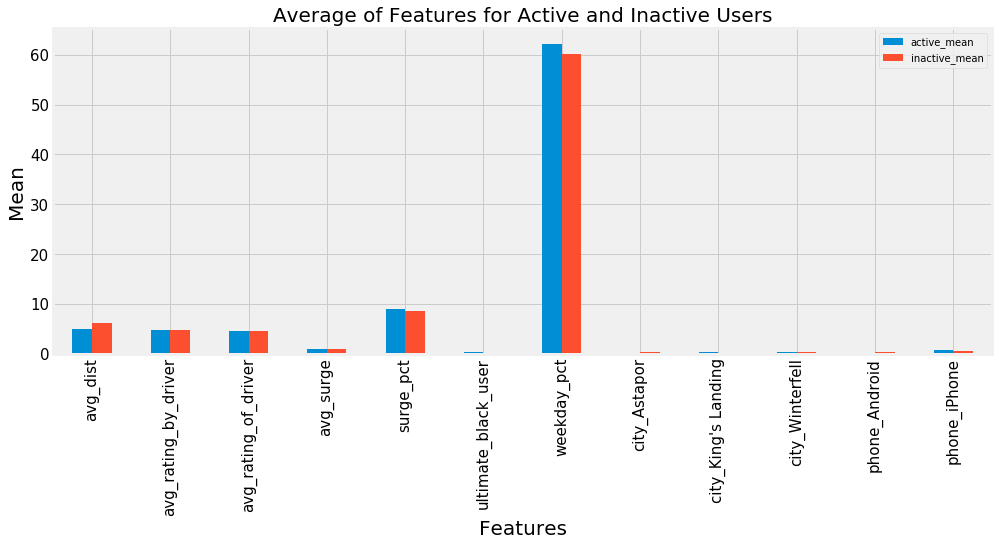

In [17]:
stats_df[['active_mean', 'inactive_mean']].plot(kind = 'bar'\
                                                , yerr=stats_df[['active_std','inactive_std']]\
                                                , figsize = (15,6)\
                                                , fontsize = 15)
plt.xlabel('Features',fontsize = 20)
plt.ylabel('Mean', fontsize = 20)
plt.title('Average of Features for Active and Inactive Users', fontsize = 20);

# Looks like there isn't a notable difference between active and inactive users in this context. 

# PART 3 - Predictive Modelling 

In [18]:
X = users_df[feature_columns]
y = users_df.active_status
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=123)

In [19]:
parameters = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

In [20]:
xg_clf = XGBClassifier(objective = 'binary:logistic', \
                       random_state = 42\
                       , silent = 1\
                       , n_estimators=10\
                       , max_depth= 8)

# RandomSearch
grid_search = GridSearchCV(param_grid= parameters, estimator = xg_clf, cv=3, scoring='accuracy')
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=8, min_child_weight=1,
                                     missing=None, n_estimators=10, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=1,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [1, 2, 3], 'learning_rate': [0.25, 0.2, 0.1],
                         'max_delta_step': [0, 0.05],
                         'min_child_

In [21]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'gamma': 3, 'learning_rate': 0.25, 'max_delta_step': 0, 'min_child_weight': 1, 'scale_pos_weight': 0.95, 'subsample': 0.8}
0.7833142857142857


In [22]:
# optimized parameters
optimized_parameters = {'objective':'binary:logistic',
                        'n_estimators': 10,
                        'random_state': 42,
                        'silent': 0,
                        'subsample': 1, 
                        'scale_pos_weight': 0.95, 
                        'min_child_weight': 1, 
                        'max_depth': 8, 
                        'max_delta_step': 0, 
                        'learning_rate': 0.2, 
                        'gamma': 3
                       }

In [23]:
# instantiate classifier
xg_clf_opt = XGBClassifier(**optimized_parameters)
xg_clf_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=3,
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.95, seed=None,
              silent=0, subsample=1, verbosity=1)

In [24]:
# predict the labels
y_opt_pred = xg_clf_opt.predict(X_train)
# score model
score = accuracy_score(y_train, y_opt_pred)
# print accuracy
print("The resulting accuracy of the optimized classifier is {}.".format(round(score,4)))

The resulting accuracy of the optimized classifier is 0.8033.


In [25]:
# instantiate classifier
xg_clf_final = XGBClassifier(objective = 'binary:logistic'\
                                         , random_state = 42\
                                         , silent = 1\
                                         , n_estimators=200\
                                         , max_depth= 8)
# train final model
xg_clf_final.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=1, subsample=1, verbosity=1)

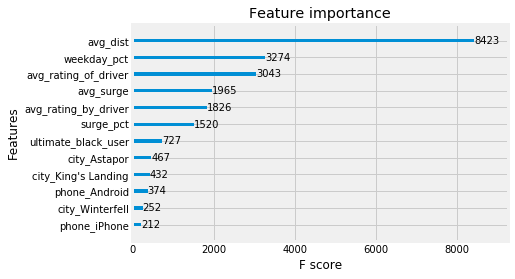

In [26]:
plot_importance(xg_clf_final);

## Reflections

* It makes since that average distance is an important measure. This is the most direct measure of how engaged the customer is in the product. It is interesting to see that weekday percentage is also an important feature. This suggests that it would be worth while to target an audience that might be more willing to use the product on weekdays. This kind of marketing would be different from targeting the weekend crowd. 
* The next largest factor is surge pricing and driver ratings. It would do well to cultivate well rated drivers and consider adjusting surge pricing. If you have highly rated drivers compared with the competition, emphasize that in your marketing. 